In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Suppress overflow warnings from sklearn/numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(over='ignore')

sns.set(style='whitegrid', context='notebook')

#Check device for NN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
df = pd.read_csv('ECGCvdata 2.csv') #replace obv
df.shape

(1200, 56)

In [3]:
df.head()

,RECORD,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,...,RMSSD,QRSarea,QRSperi,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal
0,1,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,...,292.296636,18.457618,63.615239,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,ARR
1,2,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,...,318.563915,23.043230,67.787773,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,ARR
2,3,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,...,273.165412,10.756353,29.253827,-0.042542,NaN,NaN,0.027131,16,42.105263,ARR
3,4,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,...,313.046941,23.845086,65.228737,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,ARR
4,5,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,...,263.225676,20.942791,72.830353,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,ARR


In [4]:
df.isnull().sum()

RECORD          0
hbpermin        0
Pseg            0
PQseg           0
QRSseg          0
QRseg           0
QTseg           0
RSseg           0
STseg           0
Tseg            0
PTseg           0
ECGseg          0
QRtoQSdur     769
RStoQSdur     769
RRmean          0
PPmean          0
PQdis           0
PonQdis         0
PRdis           0
PonRdis         0
PSdis           0
PonSdis         0
PTdis           0
PonTdis         0
PToffdis        0
QRdis           0
QSdis           0
QTdis           0
QToffdis        0
RSdis           0
RTdis           0
RToffdis        0
STdis           0
SToffdis        0
PonToffdis      0
PonPQang      557
PQRang        768
QRSang        769
RSTang        769
STToffang     426
RRTot           0
NNTot           0
SDRR            0
IBIM            0
IBISD           0
SDSD            0
RMSSD           0
QRSarea         0
QRSperi         0
PQslope         0
QRslope       768
RSslope       769
STslope         0
NN50            0
pNN50           0
ECG_signal

In [5]:
# Noticing a lot of NULLS with some entries not having complete data, we will see how valid those stats are 
# And decide if we are able to drop them 

In [9]:
# Replace NaNs with 0s
df.fillna(0, inplace=True)

In [15]:
#Show different results for ECG_signal
print(sorted(df['ECG_signal'].unique().tolist()))
# AFF = Atrial Fibrillation: Rapid irregular atrial activity
# ARR = Arrhythmia: Abnormal Rhytms aren't speficially labeled
# CHF = Congestive Heart Failure: Not rhytm but heart fail;ure
# NSR = Normal Sinus Rhythm: healthy regular heartbeat

['AFF', 'ARR', 'CHF', 'NSR']


In [16]:
# 
df_encoded = pd.get_dummies(df, columns=['ECG_signal'])
df_encoded.sum()

RECORD            720600.000000
hbpermin           98272.776075
Pseg                  73.082444
PQseg                 93.719023
QRSseg                57.885235
QRseg                 29.324903
QTseg                169.849209
RSseg                 28.560332
STseg                111.963973
Tseg                 123.256759
PTseg                263.568231
ECGseg               356.592907
QRtoQSdur              1.059356
RStoQSdur              1.045123
RRmean            231114.202342
PPmean            231094.044061
PQdis              23049.527807
PonQdis            32085.741286
PRdis              30276.172202
PonRdis            39316.865222
PSdis              37340.498572
PonSdis            46378.870410
PTdis              65156.208838
PonTdis            74225.433921
PToffdis           79331.910139
QRdis               7280.302738
QSdis              14294.925229
QTdis              42170.051629
QToffdis           56340.819602
RSdis               7123.787308
RTdis              34943.751666
RToffdis

In [17]:
## We are running with 0's filling the NaN's if this messes things up replace it
# With median values. Temporary

In [20]:
df_encoded.head()

,RECORD,hbpermin,Pseg,PQseg,QRSseg,QRseg,QTseg,RSseg,STseg,Tseg,...,PQslope,QRslope,RSslope,STslope,NN50,pNN50,ECG_signal_AFF,ECG_signal_ARR,ECG_signal_CHF,ECG_signal_NSR
0,1,74.925669,0.076508,0.108889,0.088254,0.043571,0.193016,0.044683,0.104762,0.130476,...,-0.014364,0.075270,-0.070846,0.012606,2,5.882353,False,True,False,False
1,2,68.503469,0.072483,0.096181,0.093924,0.046267,0.193490,0.047656,0.099566,0.089149,...,-0.021207,0.083773,-0.077458,0.016175,1,3.225806,False,True,False,False
2,3,83.488603,0.071154,0.086610,0.039530,0.018590,0.132479,0.020940,0.092949,0.094444,...,-0.042542,0.000000,0.000000,0.027131,16,42.105263,False,True,False,False
3,4,68.503469,0.082812,0.108160,0.090365,0.045226,0.188802,0.045139,0.098437,0.088281,...,-0.017806,0.091591,-0.088559,0.017022,2,6.451613,False,True,False,False
4,5,82.080000,0.070760,0.102632,0.101023,0.049415,0.193713,0.051608,0.092690,0.085965,...,-0.016650,0.064547,-0.062246,0.016191,2,5.405405,False,True,False,False


In [26]:
feature_list = ['RRmean', 'PPmean', 'RTdis', 'PonTdis', 'PonToffdis', 'QTdis',
                'IBIM', 'NN50', 'hbpermin', 'RSslope', 'RRTot', 'NNTot', 'STslope']

label_cols = [c for c in df_encoded.columns if c.startswith('ECG_signal_')]
label_cols

['ECG_signal_AFF', 'ECG_signal_ARR', 'ECG_signal_CHF', 'ECG_signal_NSR']

In [27]:
# Linear regression R^2 for EACH class (using your feature_list)
from sklearn.linear_model import LinearRegression

X = df_encoded[feature_list]
r2_table = []

for lab in df_encoded:
    y = df_encoded[lab].astype(int)  # ensure 0/1 ints
    lr = LinearRegression().fit(X, y)
    r2 = lr.score(X, y)
    r2_table.append((lab, r2))

# Show R^2 sorted (highest first)
r2_table = sorted(r2_table, key=lambda x: x[1], reverse=True)
r2_table

[('Pseg', 1.0),
 ('PQseg', 1.0),
 ('QRSseg', 1.0),
 ('QRseg', 1.0),
 ('QTseg', 1.0),
 ('RSseg', 1.0),
 ('STseg', 1.0),
 ('Tseg', 1.0),
 ('PTseg', 1.0),
 ('ECGseg', 1.0),
 ('QRtoQSdur', 1.0),
 ('RStoQSdur', 1.0),
 ('RRTot', 1.0),
 ('NNTot', 1.0),
 ('PQslope', 1.0),
 ('QRslope', 1.0),
 ('RSslope', 1.0),
 ('STslope', 1.0),
 ('NN50', 1.0),
 ('RRmean', 0.999990706204402),
 ('PPmean', 0.9999906928128574),
 ('IBIM', 0.9999870026755908),
 ('PonToffdis', 0.9999233923979339),
 ('PonTdis', 0.9999049623633814),
 ('QToffdis', 0.9998206027757107),
 ('hbpermin', 0.9997796299635952),
 ('PonRdis', 0.9997572316613194),
 ('RToffdis', 0.9997241578675315),
 ('QTdis', 0.9997086450793563),
 ('PonQdis', 0.9994909534782562),
 ('PonSdis', 0.99941183019216),
 ('RTdis', 0.9994038305980636),
 ('SToffdis', 0.9984124356989504),
 ('QRSperi', 0.9983446149317823),
 ('QRdis', 0.99804955589734),
 ('QSdis', 0.9978738783206953),
 ('QRSang', 0.997674592270778),
 ('PToffdis', 0.9968184479893303),
 ('STdis', 0.996262173438130

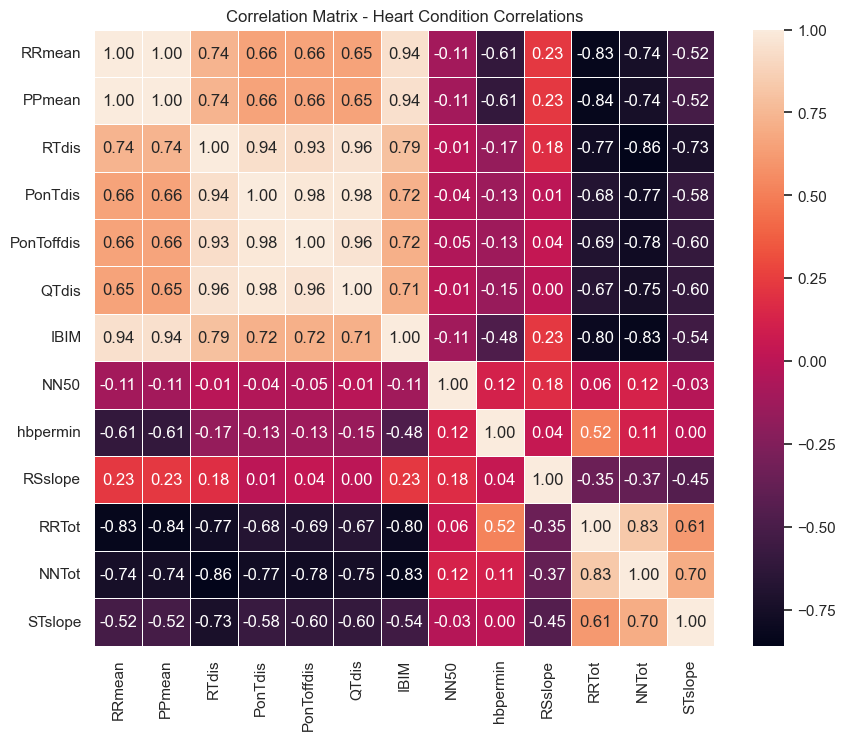

In [29]:
# Compute and visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix - Heart Condition Correlations')
plt.savefig('hc.png')
plt.show()

In [ ]:
# One note is that RRmean and PPmean being 1 is not a red flag, but should not be used 
# To train the model 